-----------------------------------------------------------------------------------------------------------------------
# **Predicting Patients' No-Show**
-----------------------------------------------------------------------------------------------------------------------

--------------------
## **Context**
--------------------

This project aims to build a model to predict patients' commitment to appointments and understand the underlying reasons behind patients' No-Show appointments. The dataset used to create the model is survey data (63 questions) collected by Ipsos Public Affairs between July and August 2020. The target population consisted of non-institutionalized adults aged 18 and older residing in the United States, with oversamples of African Americans, Hispanics, and adults in low-income households. 

Understanding what influences patients' appointments commitment can result in significant improvements, including: 
1. Resource optimization: When patients do not show up for their scheduled appointments, it underutilizes healthcare resources, such as doctors, nurses, and other support staff, as well as equipment and facilities. By predicting which patients are likely to no-show, healthcare providers can optimize their resources by scheduling appointments for patients who are more likely to show up.

2. Cost reduction: No-shows can result in high costs for healthcare providers. When appointments are not utilized, it leads to lost revenue and wasted resources. Predicting no-shows can help healthcare providers reduce costs by reallocating resources and filling appointment slots that would otherwise go unused.

3. Improved patient outcomes: No-shows can negatively impact patient outcomes, as missed appointments can lead to delayed diagnosis, treatment, and follow-up care. By predicting which patients are likely to no-show, healthcare providers can proactively reach out to patients and encourage them to attend their appointments, thereby improving patient outcomes.

4. Better patient experience: No-shows can frustrate patients and healthcare providers. Patients may become frustrated if they cannot get an appointment when needed, while healthcare providers may become frustrated if they have empty appointment slots. Healthcare providers can improve the patient experience and build trust with their patients by predicting no-shows and taking proactive measures to reduce them.


**Note:** the cleaning process was done seperatly using R.

## **Importing the libraries and overview of the dataset**

In [1]:
# load the libraries
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To create the XGBoost model and plot the XGBoost feature importance
from sklearn.inspection import permutation_importance
from xgboost import plot_importance, XGBClassifier

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the data
df= pd.read_spss("./Data/df_pos_without.sav")

In [3]:
# check the first 5 rows of the data
df.head()

,duration,DeviceType,weight,xspanish,xacslang,pphispan,xcom,xfpl100,xzip,Q1,...,Q5bin,Q10bin,Q15bin,Q18bin,Q43bin,Q49bin,Q53bin,Q55bin,Q59bin,ppgndrbin
0,59.33,3.0,1.8664,1.0,5.0,1.0,1.0,2.0,95357.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,32.10,3.0,1.7386,1.0,5.0,1.0,1.0,2.0,77581.0,3.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,313.84,10.0,0.3701,1.0,5.0,1.0,2.0,2.0,30291.0,3.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,14.96,10.0,2.1849,1.0,5.0,1.0,1.0,2.0,60160.0,3.0,...,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,24.40,4.0,0.4288,1.0,1.0,8.0,3.0,2.0,77077.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [4]:
#check the sort of data in each column
df.dtypes

duration      float64
DeviceType    float64
weight        float64
xspanish      float64
xacslang      float64
               ...   
Q49bin        float64
Q53bin        float64
Q55bin        float64
Q59bin        float64
ppgndrbin     float64
Length: 158, dtype: object

In [5]:
# check the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Columns: 158 entries, duration to ppgndrbin
dtypes: float64(158)
memory usage: 709.9 KB


In [6]:
# Checking the count of unique values in each column
df.nunique()

duration      541
DeviceType      9
weight        480
xspanish        2
xacslang        4
             ... 
Q49bin          2
Q53bin          2
Q55bin          3
Q59bin          2
ppgndrbin       2
Length: 158, dtype: int64

## **Model Building - Approach**

1. Partition the data into a train and test set.
2. Build a model on the train data.
3. Tune the model if required.
4. Test the data on the test set.

### **Partition the data into train and test**
This step will include seperating the data into:
1. the columns of data that we will use to make classification
2. the columns of data that we want to predict 

we will seperate the independent variables (X) and the dependent variable (Y)

In [7]:
# Separating the target variable and other variables

Y = df.Q12bin

X = df.drop(['Q12bin'], axis = 1)

### **One-Hot-Encoding**
One-hot encoding is a technique used to convert categorical variables into a format that can be used for machine learning models. In one-hot encoding, each categorical variable is represented as a binary vector, with each possible category represented by a single vector dimension. The dimension corresponding to the category is set to 1, and all other dimensions are set to 0.

For example, if we have a categorical variable "color" with three possible categories: red, blue, and green, we would represent it using one-hot encoding as follows:

red -> [1, 0, 0]<br>
blue -> [0, 1, 0]<br>
green -> [0, 0, 1]

One-hot encoding is important for XGBoost models because they are tree-based models that work by recursively splitting the data based on a threshold value. One-hot encoding allows the model to handle categorical variables, which cannot be directly used in their raw form by XGBoost models. Without one-hot encoding, XGBoost would treat categorical variables as continuous variables, which would lead to inaccurate results.

In addition to allowing the model to handle categorical variables, one-hot encoding can also help to reduce bias in the model by avoiding the implicit ordering of categories that can occur with other encoding techniques, such as label encoding.

In [8]:
#one hot encoding for positive data
X_encoded = pd.get_dummies(X, columns=['DeviceType','xspanish', 'xacslang', 'pphispan',
                                        'xcom','xfpl100','xzip','Q1','Q3','Q5bin','Q6','Q7',
                                        'Q10bin','Q18bin','Q32a','Q32b','Q36a','Q36b','Q36c','Q36d',
                                        'Q36e','Q36f','Q37','Q38a','Q38b','Q38c','Q38d','Q38e','Q38f',
                                        'Q38g','Q38h','Q38i','Q38j','Q39','Q40a','Q40b','Q40c',
                                        'Q40d','Q41','Q42a','Q42b','Q42c','Q42d','Q42e','Q42f',
                                        'Q42g','Q42h','Q42i','Q45a','Q45b','Q45c','Q45d','Q45e',
                                        'Q45f','Q45g','Q45h','Q45i','Q45j','Q46','PPWORKA',
                                        'Q54', 'Q55bin','Q56','Q60','Q61','Q62','Q63',
                                        'ppagect4','ppeduc','ppeducat','ppethm','pphouse',
                                        'ppincimp','ppmarit','ppmsacat','ppreg4','ppreg9','pprent',
                                        'ppstaten','ppwork','ppagecat']) 

In [9]:
# check the first 5 rows of the x_encoded data
X_encoded.head()

,duration,weight,Q2,Q4,Q8,Q9_1,Q9_2,Q9_3,Q9_4,Q9_5,...,ppwork_5.0,ppwork_6.0,ppwork_7.0,ppagecat_1.0,ppagecat_2.0,ppagecat_3.0,ppagecat_4.0,ppagecat_5.0,ppagecat_6.0,ppagecat_7.0
0,59.33,1.8664,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,32.10,1.7386,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,313.84,0.3701,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,14.96,2.1849,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,24.40,0.4288,3.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1


**Splitting the data into 70% train and 30% test set**

In [10]:
# Splitting the data using stratified sampling
x_train, x_test, y_train, y_test = train_test_split(X_encoded, Y, test_size = 0.3, random_state = 1, stratify = Y)

**Verify that using stratify, we have the same proportion of the outcome**

We see that 34% of the patients missed their scheduled medical service. Because of this, we used stratify when splitting the data above. Therefore, we maintained the same percentage of people who missed the medical service in both the training and testing sets. 

In [11]:
# check the proportion of those who missed the medical service in the original data
sum(Y)/len(Y)

0.3408695652173913

In [12]:
# check the proportion of those who missed the medical service in the training data
sum(y_train)/len(y_train)

0.3407960199004975

In [13]:
## check the proportion of those who missed the medical service in the test data
sum(y_test)/len(y_test)

0.34104046242774566

### **Model evaluation criterion**

**The model can make two types of wrong predictions:**

1. Predicting an patient will show up to the appointment when the patient doesn't show up
2. Predicting an patient will not show up to the appointment when the patient actually shows up

**Creating a function to calculate and print the classification report and confusion matrix**

In [14]:
# Creating metric function

def metrics_score(actual, predicted):
    
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Did not Miss', 'Missed'], yticklabels = ['Did not Miss', 'Missed'])
    plt.ylabel('Actual')
    
    plt.xlabel('Predicted')
    
    plt.show()

In [15]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    
    predictors: independent variables
    
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall
    
    precision = precision_score(target, pred, average = 'macro')              # To compute precision
               
    acc = accuracy_score(target, pred)                                 # To compute accuracy score
    

    # Creating a dataframe of metrics
    
    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },
        
        index = [0],
    )

    return df_perf

## **Building the model**

We will be building 3 different models:

- **Decision Tree**
- **Random Forest**
- **XGBoost**

### **Building the XGBoost Model**

- XGBoost stands for Extreme Gradient Boosting.
- XGBoost is a tree-based ensemble machine learning technique that improves prediction power and performance by improvising on the Gradient Boosting framework and incorporating reliable approximation algorithms. It is widely utilized and routinely appears at the top of competition leader boards in data science.


In [16]:
# Building XGBoost Classifier
xgb = XGBClassifier(objective='binary:logistic', seed= 42)

# Fitting the model
xgb.fit(x_train,
        y_train,
        verbose = True,
        eval_metric = 'aucpr',
        early_stopping_rounds = 10,
        eval_set = [(x_test, y_test)],
        )

[0]	validation_0-aucpr:0.41282
[1]	validation_0-aucpr:0.50890
[2]	validation_0-aucpr:0.41636
[3]	validation_0-aucpr:0.37962
[4]	validation_0-aucpr:0.36757
[5]	validation_0-aucpr:0.38405
[6]	validation_0-aucpr:0.40434
[7]	validation_0-aucpr:0.42503
[8]	validation_0-aucpr:0.43738
[9]	validation_0-aucpr:0.43596
[10]	validation_0-aucpr:0.43672
[11]	validation_0-aucpr:0.42355


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       265
         1.0       0.92      0.65      0.76       137

    accuracy                           0.86       402
   macro avg       0.88      0.81      0.83       402
weighted avg       0.87      0.86      0.85       402



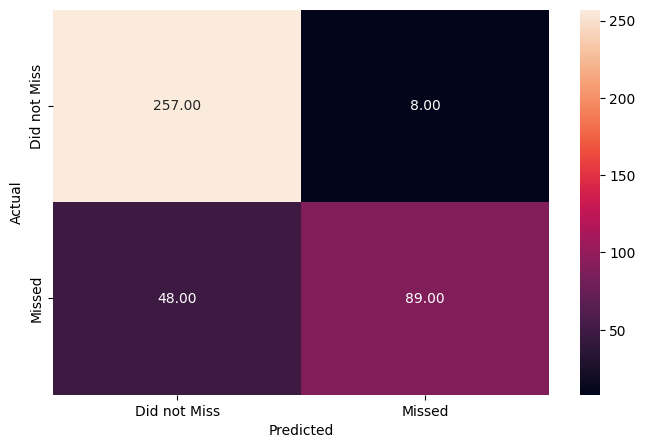

In [31]:
# Checking performance on the training data
y_pred_train_xgb = xgb.predict(x_train)

metrics_score(y_train, y_pred_train_xgb)

In [32]:
# Model Performance on the train data
xgb_perf_train = model_performance_classification(xgb,x_train,y_train)

xgb_perf_train

,Precision,Recall,Accuracy
0,0.880074,0.809723,0.860697


              precision    recall  f1-score   support

         0.0       0.73      0.84      0.78       114
         1.0       0.57      0.41      0.48        59

    accuracy                           0.69       173
   macro avg       0.65      0.62      0.63       173
weighted avg       0.68      0.69      0.68       173



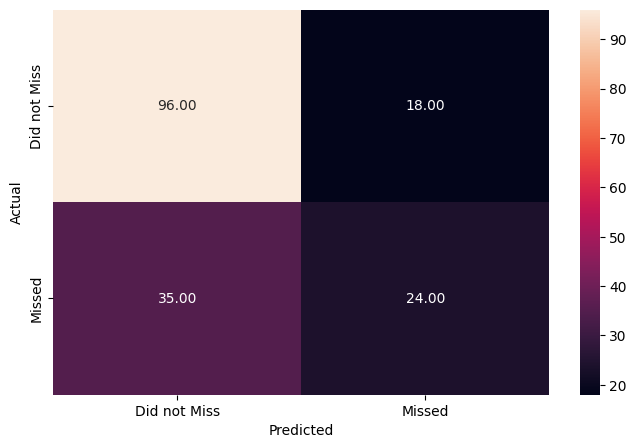

In [19]:
# Checking performance on the testing data
y_pred_test_xgb = xgb.predict(x_test)

metrics_score(y_test, y_pred_test_xgb)

In [30]:
# Model Performance on the test data
xgb_perf_test = model_performance_classification(xgb,x_test,y_test)

xgb_perf_test

,Precision,Recall,Accuracy
0,0.652126,0.624442,0.693642


**Observations** The model did not misclasify any of those who did not miss their appointments. However, it did misclasified four patients who missed their medical service as did not miss. Therefore, The F1 score for the (No, did not miss) category is higher (0.98) than the (Yes, missed) category (0.96). 
The accuracy is 98%, which is good. 

### **Optimize Parameters Using Cross Validation and GridSearch()**

Now we will optimize the model to hopefully reduce the number of misclasified patients. 

The hyperparameters that we will use to optimize the model are:<br>
1. **max_depth**: maximum tree depth<br>
2. **learning_rate**: the learning rate or eta<br>
3. **gamma**: a parameter that encourages pruning<br>
4. **reg_lambda**: the regulization parameter lambda

Moreover, we will use **GridSearchCV()** to specify a range of potential values for the hyperparameters, and **GRidSearchCV()** will test them all.

In [20]:
## ROUND 1
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.25, 1.0, 5.0],
    'reg_lambda': [0, 1, 5],
    'scale_pos_weight': [1, 2, 5]
}

In [21]:
# Creating the GridSearchCV object
# To spead up the cross validation, and further prevent overfitting,
# we will only use a random subset of the data (90%)
# and a randome subset of the features (50%) per tree
optimal_params = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic',
                                                         seed= 42,
                                                         subsample = 0.9,
                                                         colsample_bytree = 0.5),
                                param_grid = param_grid,
                                scoring = 'roc_auc',
                                cv = 3,
                                verbose = 0,
                                n_jobs = 10)

# Fitting the model
optimal_params.fit(x_train,
                    y_train,
                    verbose = False,
                    eval_metric = 'auc',
                    early_stopping_rounds = 10,
                    eval_set = [(x_test, y_test)])

# Printing the optimal parameters and best score
print('Best Parameters: ', optimal_params.best_params_)

Best Parameters:  {'gamma': 5.0, 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 0, 'scale_pos_weight': 1}


Since the best parameters showed that **learning_rate** and **gamma** took the highest values in the range of parameters, we will test another and higher range for Round 2.

In [22]:
## ROUND 2
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05],
    'gamma': [5],
    'reg_lambda': [0],
    'scale_pos_weight': [1]
}

In [23]:
# Creating the GridSearchCV object
optimal_params = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic',
                                                         seed= 42,
                                                         subsample = 0.9,
                                                         colsample_bytree = 0.5),
                                param_grid = param_grid,
                                scoring = 'roc_auc',
                                cv = 3,
                                verbose = 0,
                                n_jobs = 10)

# Fitting the model
optimal_params.fit(x_train,
                    y_train,
                    verbose = False,
                    eval_metric = 'auc',
                    early_stopping_rounds = 10,
                    eval_set = [(x_test, y_test)])

# Printing the optimal parameters and best score
print('Best Parameters: ', optimal_params.best_params_)

Best Parameters:  {'gamma': 5, 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 0, 'scale_pos_weight': 1}


Now we have the best parameter values for the final XGBoost model.


### **Building, Evaluating, and Interpreting the Optimized XGBoost Model**

In [24]:
xgb_pruned= XGBClassifier(seed=42,
                        objective='binary:logistic',
                        gamma=5,
                        learning_rate=0.05,
                        max_depth=6,
                        reg_lambda=0,
                        scale_pos_weight=1,
                        subsample=0.9,
                        colsample_bytree=0.5)

# Fitting the model
xgb_pruned.fit(x_train,
        y_train,
        verbose = True,
        eval_metric = 'aucpr',
        early_stopping_rounds = 10,
        eval_set = [(x_test, y_test)],
        )

[0]	validation_0-aucpr:0.38202
[1]	validation_0-aucpr:0.40623
[2]	validation_0-aucpr:0.40906
[3]	validation_0-aucpr:0.39589
[4]	validation_0-aucpr:0.42206
[5]	validation_0-aucpr:0.43747
[6]	validation_0-aucpr:0.44797
[7]	validation_0-aucpr:0.47089
[8]	validation_0-aucpr:0.45680
[9]	validation_0-aucpr:0.47433
[10]	validation_0-aucpr:0.48930
[11]	validation_0-aucpr:0.51354
[12]	validation_0-aucpr:0.51770
[13]	validation_0-aucpr:0.49037
[14]	validation_0-aucpr:0.51934
[15]	validation_0-aucpr:0.49704
[16]	validation_0-aucpr:0.49683
[17]	validation_0-aucpr:0.51368
[18]	validation_0-aucpr:0.52142
[19]	validation_0-aucpr:0.52013
[20]	validation_0-aucpr:0.51993
[21]	validation_0-aucpr:0.52476
[22]	validation_0-aucpr:0.51976
[23]	validation_0-aucpr:0.52374
[24]	validation_0-aucpr:0.52243
[25]	validation_0-aucpr:0.52664
[26]	validation_0-aucpr:0.52211
[27]	validation_0-aucpr:0.51665
[28]	validation_0-aucpr:0.51297
[29]	validation_0-aucpr:0.51593
[30]	validation_0-aucpr:0.51921
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       265
         1.0       0.99      0.77      0.86       137

    accuracy                           0.92       402
   macro avg       0.94      0.88      0.90       402
weighted avg       0.93      0.92      0.91       402



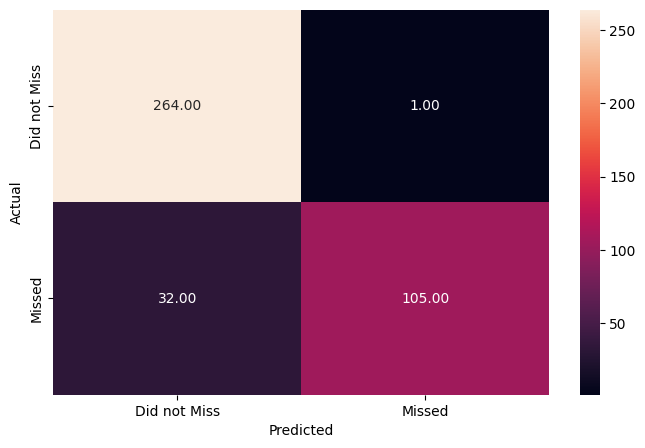

In [33]:
# Checking performance on the training data
y_pred_train_xgb = xgb_pruned.predict(x_train)

metrics_score(y_train, y_pred_train_xgb)

              precision    recall  f1-score   support

         0.0       0.69      0.89      0.78       114
         1.0       0.54      0.24      0.33        59

    accuracy                           0.67       173
   macro avg       0.62      0.57      0.56       173
weighted avg       0.64      0.67      0.63       173



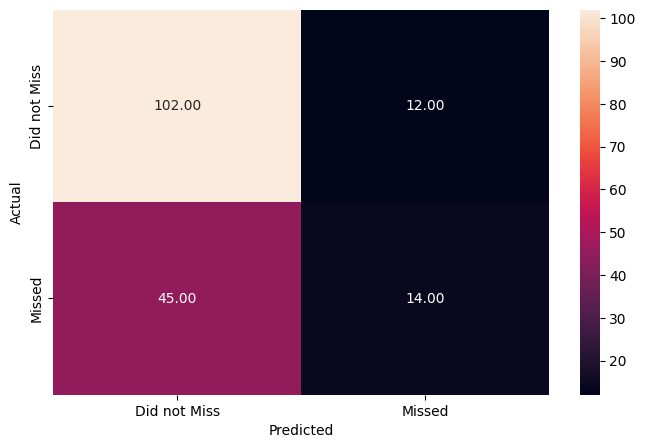

In [34]:
# Checking performance on the testing data
y_pred_test_xgb = xgb_pruned.predict(x_test)

metrics_score(y_test, y_pred_test_xgb)

In [27]:
# Model Performance on the test data
xgb_perf_pruned_test = model_performance_classification(xgb_pruned,x_test,y_test)

xgb_perf_pruned_test

,Precision,Recall,Accuracy
0,0.61617,0.566012,0.67052


**Observations:** although we optimized the model, the performance did not improve or change. 

### **Plotting Feature Importance**

In [28]:
sorted_idx = np.argsort(xgb_pruned.feature_importances_)[::-1]
for index in sorted_idx:
    print([x_train.columns[index], xgb_pruned.feature_importances_[index]])


['pphispan_2.0', 0.012520915]
['ppeduc_12.0', 0.012127283]
['Q9_2', 0.012024259]
['Q46_4.0', 0.011840653]
['Q42i_2.0', 0.011618123]
['Q45d_2.0', 0.011528758]
['Q45i_1.0', 0.010949043]
['ppt18ov', 0.010538003]
['Q10bin_1.0', 0.010241732]
['Q38b_0.0', 0.0101765515]
['Q32a_1.0', 0.009987602]
['Q3_3.0', 0.009916978]
['Q26_7', 0.009891903]
['Q21', 0.009874085]
['Q4', 0.00965481]
['Q51', 0.009632658]
['ppincimp_4.0', 0.009460735]
['Q40a_2.0', 0.009380333]
['ppwork_1.0', 0.009372009]
['Q44_3', 0.009337986]
['ppagecat_4.0', 0.00929289]
['Q44_2', 0.009174223]
['Q40d_3.0', 0.009164586]
['Q22', 0.009056903]
['Q32b_3.0', 0.009036199]
['pphouse_1.0', 0.008961636]
['Q5bin_0.0', 0.008769205]
['Q36a_1.0', 0.008754089]
['pphhhead', 0.008646046]
['Q45g_3.0', 0.008610649]
['Q38c_3.0', 0.008609978]
['Q10bin_2.0', 0.008597819]
['Q36a_3.0', 0.008582531]
['Q25', 0.0085784625]
['Q37_2.0', 0.008488756]
['Q33', 0.0084341215]
['Q40d_1.0', 0.008427059]
['Q42i_4.0', 0.008405345]
['ppage', 0.008400873]
['pphispan_8

<Axes: xlabel='Importance'>

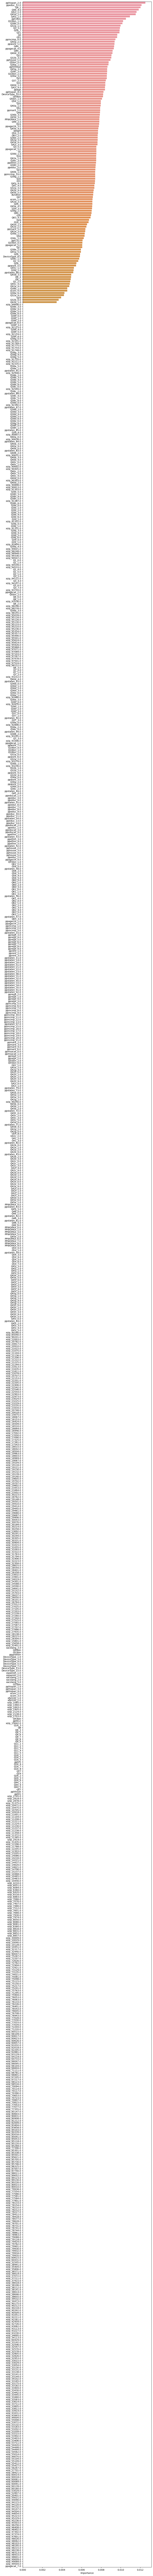

In [29]:
# Plotting feature importance
importances = xgb_pruned.feature_importances_

columns = X_encoded.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (10, 200))

sns.barplot(x= importance_df.Importance, y= importance_df.index)